# Here I implement Radial Basis Function Networks

In [1]:
# This is taken from 
# http://www.rueckstiess.net/research/snippets/show/72d2363e
# and modified subsequently to allow for the Least Squares algorithm to build the hidden layer.

#from scipy import *
from scipy.linalg import norm, pinv
from matplotlib import pyplot as plt
import numpy as np

class RBF:
     
    def __init__(self, indim, centers, betas, outdim,):
        self.indim = indim
        self.outdim = outdim
        numCenters = len(centers)
        if numCenters != len(betas):
            print 'number of centers and betas must be the same.'
#        self.numCenters = numCenters
        self.numCenters = numCenters
#        self.centers = [random.uniform(-1, 1, indim) for i in xrange(numCenters)]
        self.centers = centers
        self.beta    = betas
#        self.beta = 8
        self.W = np.random.rand(self.numCenters, self.outdim)
         
    def _basisfunc(self, c, d, bval):
        assert len(d) == self.indim
        return np.exp(-1 * norm(bval*(c-d)**2))
      
     
    def _calcAct(self, X):
        # calculate activations of RBFs
#        G = np.zeros((np.array(X).shape[0], self.numCenters), float)
        G = np.zeros([len(X), self.numCenters])
        for ci, c in enumerate(self.centers):
            beta_ci = self.beta[ci]
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x, beta_ci)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1
            idx: indices of training set objects acting as prototypes """
         
        # choose random center vectors from training set
        #rnd_idx = random.permutation(X.shape[0])[:self.numCenters]
        #self.centers = [X[i,:] for i in rnd_idx]
        #self.centers = [X[i,:] for i in idx] 
        #print "center", self.centers
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print G
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y
 
 


In [2]:
#load databases
#DataDir = './data/'
DataDir = '.'
import pickle
dset = pickle.load(open('%s/training_full.data'%DataDir))
print dset.keys()


featnames = ['dm_j0660','J0378','J0395','J0410','J0430','J0515',
             'J0660','J0861','uSDSS','gSDSS','rSDSS','iSDSS','zSDSS']

ntrain = len(dset['obj'])
feat_arr = []
err_arr = []
import itertools

colfeats = ['uSDSS','gSDSS','rSDSS','iSDSS','zSDSS']

terms = colfeats # create all colour combinations
nterms = len(terms)
ncomb = int(nterms*(nterms-1)/2.)
print 'All colours:', ncomb
comb = list(itertools.combinations(terms,2))
lcomb = list(comb)
colournames = ['%s - %s'%(x[0], x[1]) for x in list(comb)]

for x in range(ntrain):
    fx = []
    ex = []
    for y in featnames:
        fx.append(dset[y][x,0])
        ex.append(dset[y][x,1])
    for z in range(ncomb):
        fx.append(dset[lcomb[z][0]][x,0] - dset[lcomb[z][1]][x,0])
        ex.append(np.sqrt((dset[lcomb[z][0]][x,1])**2 + (dset[lcomb[z][1]][x,1])**2))
    
    feat_arr.append(fx)
    err_arr.append(ex)
class_arr = dset['class']
featnames += colournames
print featnames, len(featnames)
nfeat = len(featnames)

print err_arr[0]

['rSDSS', 'iSDSS', 'obj', 'gSDSS', 'J0395', 'zSDSS', 'J0378', 'J0430', 'uSDSS', 'dm_j0660', 'J0660', 'J0410', 'J0515', 'J0861', 'class']
All colours: 10
['dm_j0660', 'J0378', 'J0395', 'J0410', 'J0430', 'J0515', 'J0660', 'J0861', 'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS', 'uSDSS - gSDSS', 'uSDSS - rSDSS', 'uSDSS - iSDSS', 'uSDSS - zSDSS', 'gSDSS - rSDSS', 'gSDSS - iSDSS', 'gSDSS - zSDSS', 'rSDSS - iSDSS', 'rSDSS - zSDSS', 'iSDSS - zSDSS'] 23
[0.04010768632720834, 0.0589785911, 0.0621594563, 0.0520535745, 0.0487733074, 0.0379384756, 0.0307152551, 0.0340617932, 0.04083416, 0.009959696, 0.01152701, 0.01310302, 0.02982839, 0.042031228477383525, 0.04242994912141305, 0.042884936236702045, 0.0505683841238545, 0.01523376197636408, 0.016458574589945995, 0.03144723190369092, 0.01745167879203889, 0.03197819271835418, 0.03257947180530249]


Below a resampled set is generated using `SMOTE`. This will be used as training set. However, protoypes will be drawn from the original training set, which has errors associated. However, I'm not sure of the impact of class imbalance here...

In [3]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from collections import Counter

Xt = feat_arr
y  = dset['class']

# Re-sampling using SMOTE to balance classes
X_res, Y_res = SMOTE(sampling_strategy='not majority').fit_resample(Xt, y)

def class_to_int(istr):
    if istr == 'Halpha':
        return 0
    elif istr == 'OIII+Hbeta':
        return 1
    if istr == 'OII':
        return 2
    elif istr == 'contaminant':
        return 3
    else:
        print '%s not recognised'%istr
        return -99


y_rsc = [class_to_int(x) for x in Y_res]
y_train = [class_to_int(x) for x in y]

Scaledata = True
if Scaledata:
    print 'scaling data...',
    scaler = StandardScaler()
    scaler.fit(X_res)
    x_rsc = scaler.transform(X_res)
    x_train  = scaler.transform(Xt)
    print 'done'

outdim = len(np.unique(y_rsc))
print(sorted(Counter(y_rsc).items()))


scaling data... done
[(0, 666), (1, 666), (2, 666), (3, 666)]


In [4]:
# Choose prototypes
import multiprocessing as mp

nproc = 4  # number of parallel processes
prot_mu = [] # list of ids with all prototypes found
prot_be = []
temp_prot_id = [] #
err_t0 = 100
err_t = 99.9
nprot= 1

def get_pred(z):
    pred = [np.round(x) for x in z]
    gt3 = pred >3
    pred[gt3] = 3 # those that were rounded to 4 are set to 3
    return pred


nlist = 40
npc = int(nlist / 4.)
# pick a random subset from each class
idlist = []

for i in range(4):
    sel = np.where(np.array(y_train) == i)[0]
#    print sel
    idlist.append(np.random.choice(sel, npc))

idlist = list(np.array(idlist).flatten())
print idlist              

beta_arr = 1./(2*np.array(err_arr)**2)
#idlist = list(np.random.choice(ntrain, 32))
#idlist = list(np.arange(0,ntrain))
max_prot = len(idlist)
print max_prot

all_errors = []


while ((err_t0 >= err_t) and (nprot < max_prot)) or nprot < 5: # while error improves and number of prototypes < max_prot
    err_t0 = err_t
    errors = []
    i0 = 0
    i1 = len(idlist)
    if i1 > nproc: # if there's a need to parallelise
        npp = int((i1-i0+1.0)/(nproc+0.0)) # number of prototype testings per processor
      #  print 'Number per processor:',npp

        def get_errors(idlist, _i0, _i1):
            for _it in xrange(_i0,_i1):
    #    for it in idlist:
                it = idlist[_it]
                mu_it = [x_train[it]]
                beta_it = [beta_arr[it]]
                if len(prot_mu) > 0:
                    mu_arr = list(prot_mu) ; mu_arr.append(mu_it)
                    b_arr  = list(prot_be) ; b_arr.append(beta_it)
        #            print 'length of mu_arr %d'%len(mu_arr)
                else:
                    mu_arr = [mu_it]
                    b_arr = [beta_it]

#                if it == idlist[0]:
#                     print 'prototypes found %d'%len(prot_mu)
                rbf = RBF(nfeat,mu_arr,b_arr,outdim)
                tr = rbf.train(x_rsc,y_rsc)
                pred = get_pred(rbf.test(x_rsc))
                errors.append(1 - balanced_accuracy_score(y_rsc, pred,adjusted=True))
              #  print 'Error rate: %.4f'% errors[-1]
            return errors

        def run_prot_test(ip):
            _i0 = npp*ip
            _i1 = npp*(ip+1)
            if ip == nproc-1:
                _i1 = len(idlist)  # last process is forced to reach the last sub-volume
                print 'last process goes from indices %d to %d'%(_i0,_i1)
            return get_errors(idlist, _i0, _i1)

        pool = mp.Pool(processes=nproc)
        results = [pool.apply(run_prot_test, args=(x,)) for x in range(nproc)]
#        results = [p.get() for p in res]
        print 'joining all results...'
        errors = np.concatenate([results[i] for i in range(nproc)])
        pool.terminate()
        pool.join()

    else:
        print 'not running in parallel'
        errors = get_errors(idlist, 0, len(idlist))
        
    best_prot = np.argmin(errors)
    prot_mu.append(x_train[idlist[best_prot]])
    prot_be.append(beta_arr[idlist[best_prot]])
    del idlist[best_prot]
    err_t = errors[best_prot]
    nprot = len(prot_mu)
    all_errors.append(err_t)
    print 'error:%.3f, error_0:%.3f, d_err:%.3f, len(objs):%d'%(err_t, err_t0, err_t-err_t0,len(idlist))
    

[26, 7, 19, 5, 4, 14, 3, 28, 29, 0, 32, 23, 10, 11, 23, 18, 23, 25, 10, 22, 30, 702, 712, 749, 745, 717, 721, 744, 719, 742, 258, 615, 637, 654, 576, 234, 464, 349, 329, 574]
40
last process goes from indices 30 to 40
joining all results...
error:0.996, error_0:99.900, d_err:-98.904, len(objs):39
last process goes from indices 30 to 39
joining all results...
error:0.992, error_0:0.996, d_err:-0.004, len(objs):38
last process goes from indices 27 to 38
joining all results...
error:0.989, error_0:0.992, d_err:-0.004, len(objs):37
last process goes from indices 27 to 37
joining all results...
error:0.985, error_0:0.989, d_err:-0.004, len(objs):36
last process goes from indices 27 to 36
joining all results...
error:0.982, error_0:0.985, d_err:-0.004, len(objs):35
last process goes from indices 27 to 35
joining all results...
error:0.979, error_0:0.982, d_err:-0.003, len(objs):34
last process goes from indices 24 to 34
joining all results...
error:0.976, error_0:0.979, d_err:-0.003, len(obj

Text(0,0.5,'Error')

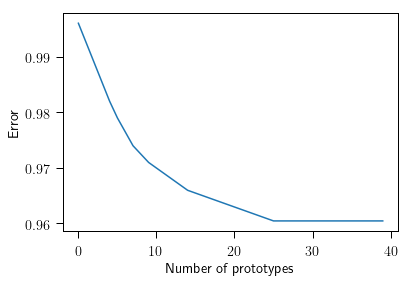

In [5]:
import matplotlib.pyplot as plt

plt.plot(all_errors)
plt.xlabel('Number of prototypes')
plt.ylabel('Error')
